<a href="https://colab.research.google.com/github/Jeremy26/tracking_course/blob/master/2_Hungarian_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to the Tracking Project!

In this project, you will learn to associate bounding boxes on multiple frames using the Hungarian Algorithm!

You will work on 3 aspects of the **multi-object tracker**:

*   Use YOLO and launch an object detection algorithm
*   Use The Hungarian Algorithm and associate the boxes
*   Improve the algorithm to avoid false positives and false negatives

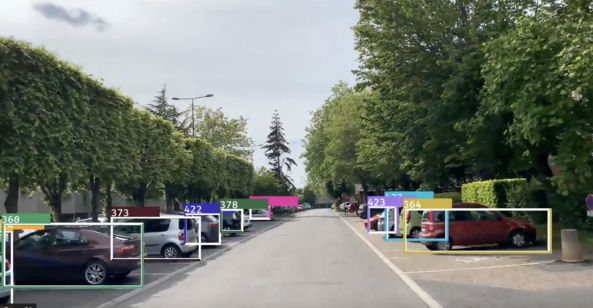

In [ ]:
!wget https://thinkautonomous-tracking.s3.eu-west-3.amazonaws.com/tracking_course.zip && unzip tracking_course.zip

## Imports

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import copy
import glob
import pickle
import cv2
import numpy as np

## Load & Visualize the Images

In [3]:
def visualize_images(input_images):
    fig=plt.figure(figsize=(150,75))
    for i in range(len(input_images)):
        fig.add_subplot(1, len(input_images), i+1)
        plt.imshow(input_images[i])
    plt.show()

In [10]:
images_files = sorted(glob.glob("tracking_course/data/*.png"))
images = []

#Indexes to test on:
# 100 — Same number of detections
# 300 — 2 Lost Tracks
# 782 — 1 New Detection
# 654 — Edge Case

index = 782
for img in images_files[index:index+2]:
    images.append(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB))

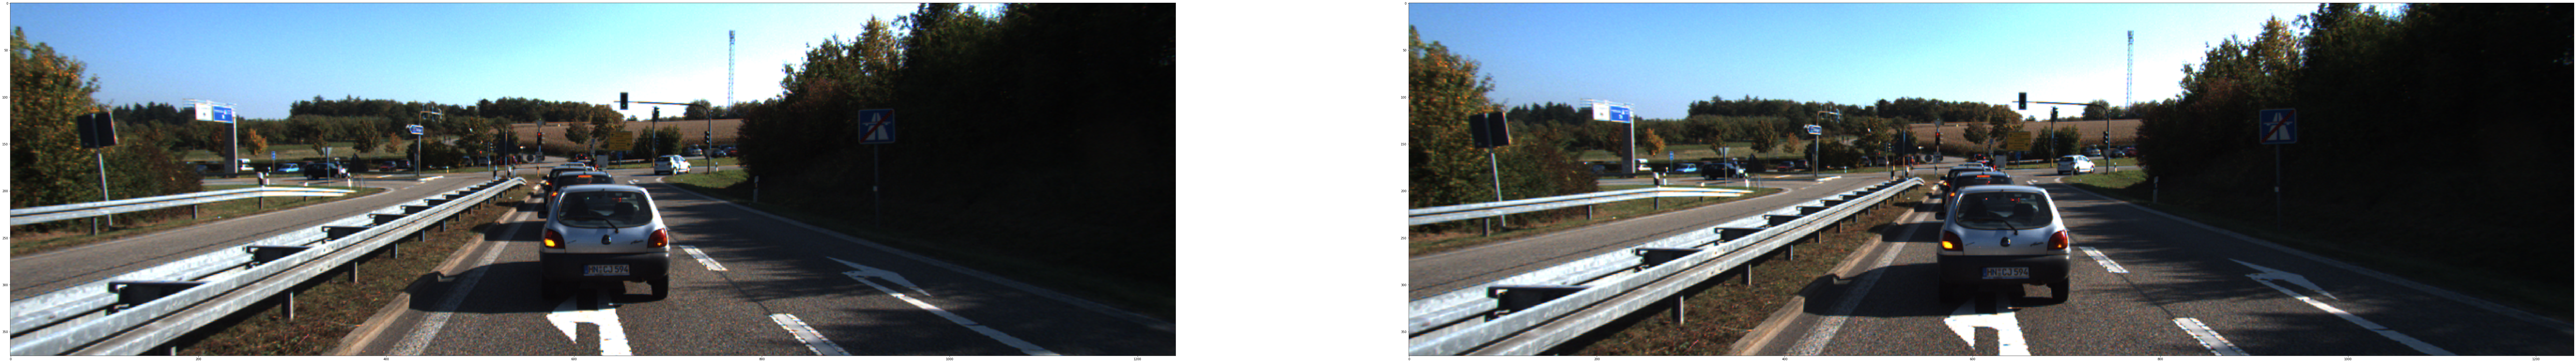

In [11]:
visualize_images(images)

## 1) YOLOv5 — Object Detection

-- Just copy and paste the parts from the object detection workshop

In [ ]:
!pip install yolo5 # version 0.0.1 used at the moment of recording

In [13]:
import yolov5
model = yolov5.load('tracking_course/yolov5s.pt')

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
print(help(model))

In [15]:
model.conf = 0.5
model.iou = 0.4

In [16]:
classesFile = "tracking_course/coco.names"
with open(classesFile,'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

def id_to_color(idx):
    """
    Random function to convert an id to a color
    Do what you want here but keep numbers below 255
    """
    blue = idx*5 % 256
    green = idx*12 %256
    red = idx*23 %256
    return (red, green, blue)

def draw_boxes_v5(image, boxes, categories, mot_mode=False):
    h, w, _ = image.shape
    for i, box in enumerate(boxes):
        label = classes[int(categories[i])]
        color = id_to_color(i*10) if mot_mode==True else (255,0,0)
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, thickness=7)
        cv2.putText(image, str(label), (int(box[0]), int(box[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), thickness=3)
    return image

def inference(img):
    results = model(img)
    predictions = results.pred[0]
    boxes = predictions[:, :4].tolist()
    boxes_int = [[int(v) for v in box] for box in boxes]
    scores = predictions[:,4].tolist()
    categories = predictions[:,5].tolist()
    categories_int = [int(c) for c in categories]
    img_out = draw_boxes_v5(img, boxes_int, categories_int, mot_mode=True)
    return img_out, boxes_int, categories_int, scores

In [17]:
yolo_images = []
yolo_boxes = []
yolo_categories = []
yolo_scores = []
pics = copy.deepcopy(images)

for img in pics:
    result, pred_bboxes, pred_categories, pred_scores = inference(img)
    yolo_boxes.append(pred_bboxes)
    yolo_images.append(result)
    yolo_categories.append(pred_categories)
    yolo_scores.append(pred_scores)

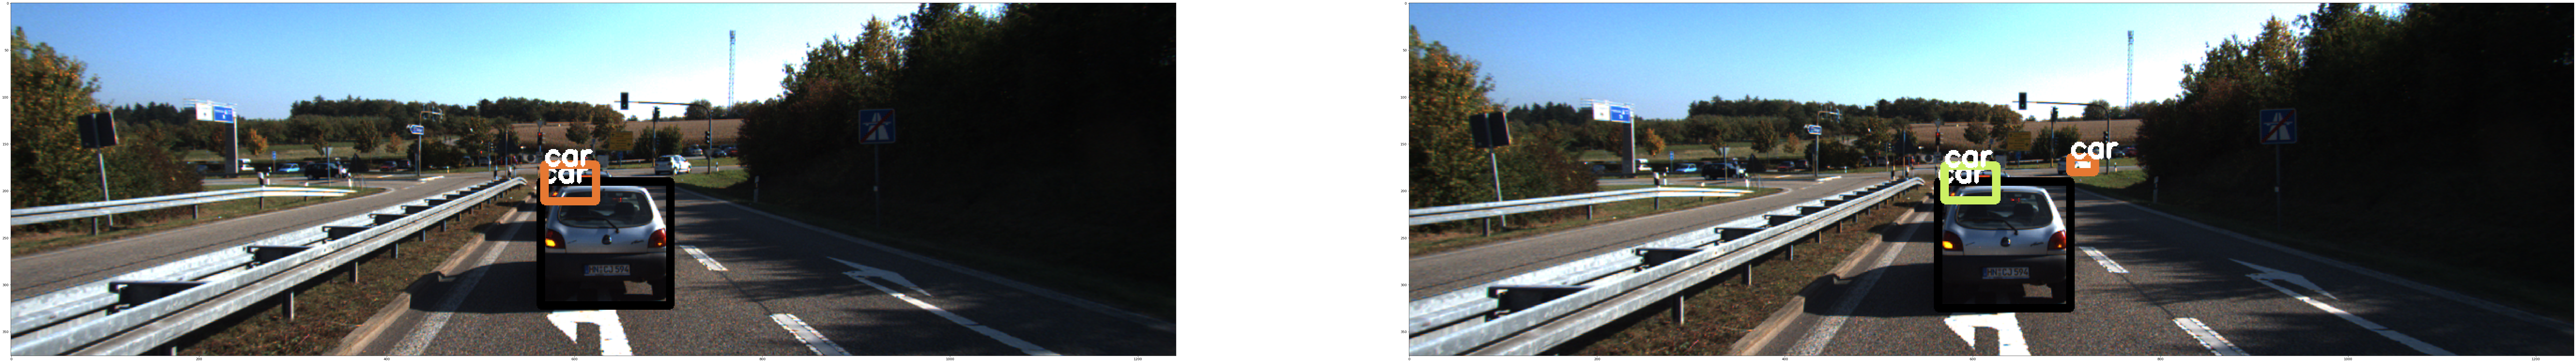

In [18]:
visualize_images(yolo_images)

In [19]:
print("Frame 1")
print(yolo_boxes[0])
print(yolo_categories[0])
print(yolo_scores[0])
print("Frame 2")
print(yolo_boxes[1])
print(yolo_categories[1])
print(yolo_scores[1])

Frame 1
[[564, 190, 702, 322], [568, 172, 623, 211]]
[2, 2]
[0.87353515625, 0.60107421875]
Frame 2
[[563, 190, 704, 325], [704, 164, 730, 180], [570, 173, 625, 210]]
[2, 2, 2]
[0.8671875, 0.6044921875, 0.56396484375]


## 2) Hungarian Algorithm

In [20]:
def box_iou(box1, box2, w = 1280, h=360):
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    inter_area = max(0, xB - xA + 1) * max(0, yB - yA + 1) #abs((xi2 - xi1)*(yi2 - yi1))
    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1) #abs((box1[3] - box1[1])*(box1[2]- box1[0]))
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1) #abs((box2[3] - box2[1])*(box2[2]- box2[0]))
    union_area = (box1_area + box2_area) - inter_area
    # compute the IoU
    iou = inter_area/float(union_area)
    return iou

In [21]:
def check_division_by_0(value, epsilon=0.01):
    if value < epsilon:
        value = epsilon
    return value

Add the other cost metrics according to this paper: https://arxiv.org/pdf/1709.03572.pdf (formulas page 10 and 11)

In [22]:
def sanchez_matilla(box1, box2, w = 1280, h=360):
    Q_dist = sqrt(pow(w,2)+pow(h,2)) # First real-life Pythagore use in your life
    Q_shape = w*h
    distance_term = Q_dist/check_division_by_0(sqrt(pow(box1[0] - box2[0], 2)+pow(box1[1] -box2[1],2)))
    shape_term = Q_shape/check_division_by_0(sqrt(pow(box1[2] - box2[2], 2)+pow(box1[3] - box2[3],2)))
    linear_cost = distance_term*shape_term
    return linear_cost

In [23]:
from math import sqrt, exp

def yu(box1, box2):
    w1 = 0.5
    w2 = 1.5
    a= (box1[0] - box2[0])/check_division_by_0(box1[2])
    a_2 = pow(a,2)
    b = (box1[1] - box2[1])/check_division_by_0(box1[3])
    b_2 = pow(b,2)
    ab = (a_2+b_2)*w1*(-1)
    c = abs(box1[3] - box2[3])/(box1[3]+box2[3])
    d = abs(box1[2]-box2[2])/(box1[2]+box2[2])
    cd = (c+d)*w2*(-1)
    exponential_cost = exp(ab)*exp(cd)
    return exponential_cost

In [25]:
def total_cost(old_box, new_box, iou_thresh = 0.3, linear_thresh = 10000, exp_thresh = 0.5):
    iou_score = box_iou(old_box, new_box)
    linear_cost = sanchez_matilla(old_box, new_box)
    exponential_cost = yu(old_box, new_box)
    if (iou_score >= iou_thresh and linear_cost>=linear_thresh and exponential_cost>=exp_thresh):
        return iou_score
    else:
        return 0

### Association
From now on, we need a function that will **go over all detections from frame 1, and all detections from frame 2**, and **return the matches, new detections, and old unmatched tracks**.

In [119]:
from scipy.optimize import linear_sum_assignment

def associate(old_boxes, new_boxes):
    """
    old_boxes will represent the former bounding boxes (at time 0)
    new_boxes will represent the new bounding boxes (at time 1)
    Function goal: Define a Hungarian Matrix with IOU as a metric and return, for each box, an id
    """
    if (len(new_boxes) == 0) and (len(old_boxes) == 0):
        return [], [], []
    elif(len(old_boxes)==0):
        return [], new_boxes, []
    elif(len(new_boxes)==0):
        return [], [], old_boxes

    # Define a new IOU Matrix nxm with old and new boxes
    iou_matrix = np.zeros((len(old_boxes),len(new_boxes)),dtype=np.float32)

    # Go through boxes and store the IOU value for each box 
    # You can also use the more challenging cost but still use IOU as a reference for convenience (use as a filter only)
    for i,old_box in enumerate(old_boxes):
        for j,new_box in enumerate(new_boxes):
            iou_matrix[i][j] = total_cost(old_box, new_box)
    
    # Call for the Hungarian Algorithm
    hungarian_row, hungarian_col = linear_sum_assignment(-iou_matrix)
    hungarian_matrix = np.array(list(zip(hungarian_row, hungarian_col)))

    # Create new unmatched lists for old and new boxes
    matches, unmatched_detections, unmatched_trackers = [], [], []

    # Go through the Hungarian Matrix, if matched element has IOU < threshold (0.3), add it to the unmatched 
    # Else: add the match    
    for h in hungarian_matrix:
        if(iou_matrix[h[0],h[1]]<0.3):
            unmatched_trackers.append(old_boxes[h[0]])
            unmatched_detections.append(new_boxes[h[1]])
        else:
            matches.append(h.reshape(1,2))
    
    if(len(matches)==0):
        matches = np.empty((0,2),dtype=int)
    else:
        matches = np.concatenate(matches,axis=0)
    
    # Go through old boxes, if no matched detection, add it to the unmatched_old_boxes
    for t,trk in enumerate(old_boxes):
	    if(t not in hungarian_matrix[:,0]):
		    unmatched_trackers.append(trk)
    
    # Go through new boxes, if no matched tracking, add it to the unmatched_new_boxes
    for d, det in enumerate(new_boxes):
        if(d not in hungarian_matrix[:,1]):
                unmatched_detections.append(det)
    
    return matches, unmatched_detections,unmatched_trackers

In [27]:
print(yolo_boxes[0])
print(yolo_boxes[1])

[[564, 190, 702, 322], [568, 172, 623, 211]]
[[563, 190, 704, 325], [704, 164, 730, 180], [570, 173, 625, 210]]


In [28]:
matches, unmatched_detections, unmatched_trackers = associate(yolo_boxes[0], yolo_boxes[1])

In [29]:
print(yolo_boxes[0])
print(yolo_boxes[1])
print(matches)

[[564, 190, 702, 322], [568, 172, 623, 211]]
[[563, 190, 704, 325], [704, 164, 730, 180], [570, 173, 625, 210]]
[[0 0]
 [1 2]]


In [30]:
print(unmatched_detections)

[[704, 164, 730, 180]]


In [31]:
print(unmatched_trackers)

[]


## 3) Hungarian Tracking Loop
Finally, we just need a main function that will **implement this idea over several frames**.

In [33]:
class Obstacle():
    def __init__(self, idx, box):
        """
        Init function. The obstacle must have an id and a box.
        """
        self.idx = idx
        self.box = box

We have two lists of obstacles:
*   A list for the **old obstacles** that we will check at every frame
*   A list for the **new obstacles** that we will become the old_obstacles at the next frame.
<p>
The logic is as follows:
1. If first frame: **return and store a list of stored obstacles**.
2. Then, for every frame, **match the list of new obstacles with the stored obstacles** and **set the new list as stored_obstacles**.

In [165]:
def main(input_image):
    global stored_obstacles
    global idx

    # 1 — Run Obstacle Detection & Convert the Boxes
    final_image = copy.deepcopy(input_image)
    h, w, _ = final_image.shape
    _, out_boxes, _, _ = inference(input_image)

    #print("----> New Detections: ", out_boxes)

    # Define the list we'll return:
    new_obstacles = []

    old_obstacles = [obs.box for obs in stored_obstacles] # Simply get the boxes
    matches, unmatched_detections, unmatched_tracks = associate(old_obstacles, out_boxes) # Associate the obstacles
            
    # Matching
    for match in matches:
        obs = Obstacle(stored_obstacles[match[0]].idx, out_boxes[match[1]])
        new_obstacles.append(obs)
        #print("Obstacle ", obs.idx, " with box: ", obs.box, "has been matched with obstacle ", stored_obstacles[match[0]].box, "and now has age: ", obs.age)
    
    # New (Unmatched) Detections
    for new_obs in unmatched_detections:
        obs = Obstacle(idx, new_obs)
        new_obstacles.append(obs)
        idx+=1
        #print("Obstacle ", obs.idx, " has been detected for the first time: ", obs.box)

    # Unmatched Tracking: NO RE-IDENTIFICATION FOR NOW

    # Draw the Boxes
    for i, obs in enumerate(new_obstacles):
        left, top, right, bottom = obs.box
        cv2.rectangle(final_image, (left, top), (right, bottom), id_to_color(obs.idx*10), thickness=7)
        final_image = cv2.putText(final_image, str(obs.idx),(left - 10,top - 10),cv2.FONT_HERSHEY_SIMPLEX, 1,id_to_color(obs.idx*10),thickness=4)
    
    stored_obstacles = new_obstacles

    return final_image, stored_obstacles

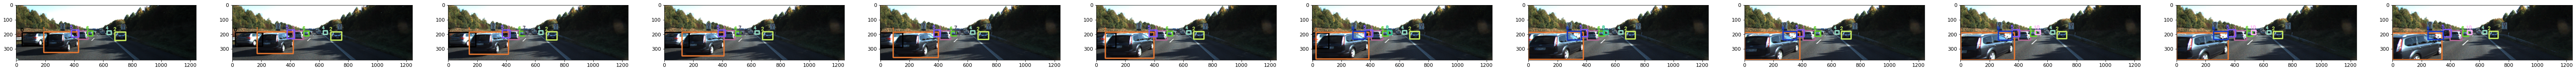

In [166]:
### Call the main loop

fig=plt.figure(figsize=(100,100))
out_imgs = []
idx = 0
stored_obstacles = []

for i in range(len(images)):
    out_img, stored_obstacles = main(images[i])
    out_imgs.append(out_img)
    fig.add_subplot(1, len(images), i+1)
    plt.imshow(out_imgs[i])

plt.show()

Try on more images

In [46]:
images = []
index = 654

# 100 — Same number of detections
# 300 — 2 Lost Tracks
# 782 — 1 New Detection
# 654 — Edge Case

for img in images_files[index-2:index+10]:
    images.append(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB))

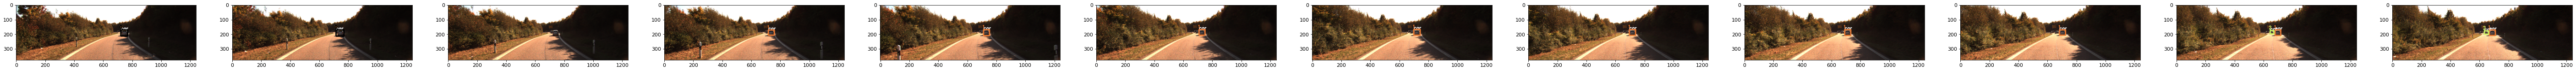

In [47]:
fig=plt.figure(figsize=(100,100))
out_imgs = []
stored_obstacles = []
idx = 0

for i in range(len(images)):
    out_img, stored_obstacles = main(images[i])
    out_imgs.append(out_img)
    fig.add_subplot(1, len(images), i+1)
    plt.imshow(out_imgs[i])

plt.show()

## Extra — Implementing Re-Identification & Ghost Removal

We now have a pretty good tracker! <p>
One thing that is not very good is that it relies solely on the detector.
If we miss the detection, we miss everything. <p>

In this part, we'll treat two issues:
* **False Positives** — ghosts, unwanted detections, ...
* **False Negatives** — missed detections.

> We'll solve the False Positive problem by introducing a **MIN_HIT_STREAK** variable. If the detector detects something once, it is not displayed. If it **detects it twice in a row**, or 3 times in a row (thanks to matching), it is displayed.

> We'll solve the False Negative Problem by introducing a **MAX_AGE** variable. If an obstacle is suddently unmatched, we **keep displaying** it. If it is unmatched again, or more times, we remove it.

In [157]:
MIN_HIT_STREAK = 1 # Number of matches required before considering an obstacle
MAX_UNMATCHED_AGE = 2 # Number of unmatches required before considering a lost track

**Obstacle Class** <p>
Let's redefine the Obstacle class to include these values
Every obstacle should have:
* an id
* a box
* an age (number of times matched)
* an unmatched frame number (number of times unmatched)

In [143]:
class Obstacle():
    def __init__(self, idx, box, age=1, unmatched_age=0):
        self.idx = idx
        self.box = box
        self.age = age
        self.unmatched_age = unmatched_age

**Main Loop** <p>
We'll now change the main loop to consider these issues:

We have two lists of obstacles:
*   A list for the **old obstacles** that we will check at every frame
*   A list for the **new obstacles** that we will become the old_obstacles at the next frame.
*   A list for **selected_obstacles** that will be displayed

<p>
The logic is as follows:

1. If first frame: **create a list of new obstacles**.
2. Then, for every frame, **match the list of new obstacles with the stored obstacles** and **set the new list as stored_obstacles**.
3. Finally, go through the criteria to **display an obstacle only if it makes the selected_list**.

In [153]:
def main_2(input_image):
    global stored_obstacles
    global idx

    # 1 — Run Obstacle Detection & Convert the Boxes
    final_image = copy.deepcopy(input_image)
    h, w, _ = final_image.shape
    _, out_boxes, _, _ = inference(input_image)

    #print("----> New Detections: ", out_boxes)

    # Define the list we'll return:
    new_obstacles = []

    old_obstacles = [obs.box for obs in stored_obstacles] # Simply get the boxes
    matches, unmatched_detections, unmatched_tracks = associate(old_obstacles, out_boxes) # Associate the obstacles
            
    # Matching
    for match in matches:
        obs = Obstacle(stored_obstacles[match[0]].idx, out_boxes[match[1]], stored_obstacles[match[0]].age +1)
        new_obstacles.append(obs)
        #print("Obstacle ", obs.idx, " with box: ", obs.box, "has been matched with obstacle ", stored_obstacles[match[0]].box, "and now has age: ", obs.age)
    
    # New (Unmatched) Detections
    for new_obs in unmatched_detections:
        obs = Obstacle(idx, new_obs)
        new_obstacles.append(obs)
        idx+=1
        #print("Obstacle ", obs.idx, " has been detected for the first time: ", obs.box)

    # Unmatched Tracking: NO RE-IDENTIFICATION FOR NOW
    for old_track in unmatched_tracks:
        i = old_obstacles.index(old_track)
        #print("Old Obstacles tracked: ", stored_obstacles[i].box)
        if i is not None:
            obs = stored_obstacles[i]
            obs.unmatched_age +=1
            new_obstacles.append(obs)
            #print("Obstacle ", obs.idx, "is a long term obstacle unmatched ", obs.unmatched_age, "times.")

    # Draw the Boxes
    for i, obs in enumerate(new_obstacles):
        if obs.unmatched_age > MAX_UNMATCHED_AGE:
            new_obstacles.remove(obs)

        if obs.age >= MIN_HIT_STREAK:
            left, top, right, bottom = obs.box
            cv2.rectangle(final_image, (left, top), (right, bottom), id_to_color(obs.idx*10), thickness=7)
            final_image = cv2.putText(final_image, str(obs.idx),(left - 10,top - 10),cv2.FONT_HERSHEY_SIMPLEX, 1,id_to_color(obs.idx*10),thickness=4)

    stored_obstacles = new_obstacles

    return final_image, stored_obstacles

In [159]:
images = []
index = 100

# 100 — Same number of detections
# 300 — 2 Lost Tracks
# 782 — 1 New Detection
# 654 — Edge Case

for img in images_files[index:index+10]:
    images.append(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB))

In [ ]:
### Call the main loop

idx = 0
fig=plt.figure(figsize=(100,100))
images_2 = copy.deepcopy(images)
out_imgs = []
stored_obstacles = []

for i in range(len(images_2) - 5):
    out_img, stored_obstacles = main_2(images_2[i])
    out_imgs.append(out_img)
    fig.add_subplot(1, len(images_2), i+1)
    plt.imshow(out_imgs[i])

plt.show()

# Video


Now is the time to run on a video. 

In [ ]:
import glob
from tqdm import tqdm

video_images = sorted(glob.glob("tracking_course/data/*.png"))
result_video = []
idx = 0
stored_obstacles = []

for img in tqdm(video_images):
    out_img, stored_obstacles = main_2(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB))
    result_video.append(out_img)

In [162]:
out = cv2.VideoWriter('out_hungarian.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 15, (out_img.shape[1],out_img.shape[0]))

for img in result_video:
  out.write(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
out.release()

In [163]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('out_hungarian.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)